In [1]:
import sys
import h5py
import glob
import numpy as np 
import matplotlib.pyplot as plt
from scipy import signal
import scipy as sp
from scipy.signal import butter
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel
import time

### Import & parameter definitions ###

In [8]:
# reading h5 file
f = h5py.File("20190518_173944_projection-Copy1.h5")
list(f.keys())
shots = f.get("n-shots")
photE = f.get("x-axis")
intense = f.get("y-axis")
spectrum = range(0,len(intense[:,1]-1)) # for parameter redefinition

In [9]:
# Parameters
lpcutoff = 0.005             # Cut-off frequency for low-pass filter
heightcut = 10                # Height percentage cut we filter peaks by
dx = 0.1                     # NN Distance threshold
sidecut = 5                  # Edge cut percentage threshold
deg = 5                      # Low-pass filter order
lowpassdata = intense[25,:]  # Spectrum for which we test, to loop over

### Single spectrum example procedure ###

/Users/Sara/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


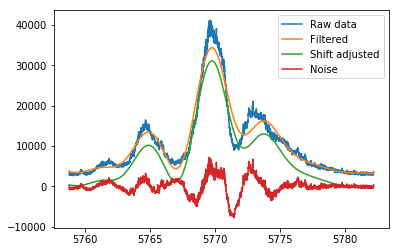

In [10]:
fn = lowpass(lowpassdata,lpcutoff)
fn.plotlowpass()

Preliminary peak finding

In [11]:
# Eliminating peaks closer than dx to each other and closer to edge than sidecut

fn = FilterPeaks(lowpassdata,lpcutoff, dx, sidecut)
if fn.n > 1:
    cond = fn.EliminatePeaks()
n = cond.shape[1]

0 3
FWHM width of peak 1 :  2.6168273558009636
Sigma of peak 1 :  1.1112642816864828
1 3
FWHM width of peak 2 :  2.804864046581185
Sigma of peak 2 :  1.1911161135803097
2 3
FWHM width of peak 3 :  3.1553863024636555
Sigma of peak 3 :  1.3399692131303689


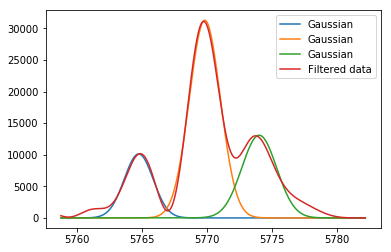

In [12]:
gaussResults = Gaussp(n,FindPeaks(lowpassdata,lpcutoff).pospeaks(),lowpass(lowpassdata,lpcutoff).data()).indiv()

In [13]:
# Creating full Gaussian for comparison
j = 0
GaussAdd = []
while j < len(gaussResults[1]):
    GaussAdd = np.append(GaussAdd, 0)
    for i in range(0,n):
        GaussAdd[j] = GaussAdd[j] + gaussResults[i,j]
    j = j+1

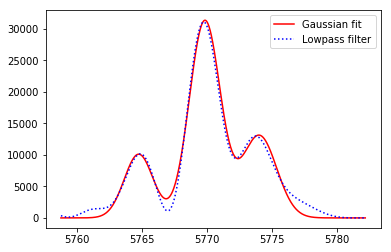

In [14]:
# Plotting raw smoothened data and added Gaussian
plt.plot(photE,GaussAdd,"r-",label='Gaussian fit')
plt.plot(photE,lowpass(lowpassdata,lpcutoff).data()[:,1],"b:", label='Lowpass filter')
plt.legend()
#for i in range(n):
#    plt.plot(photE,gaussResults[i,:], label='Indiv. Ga')

In [15]:
func = MaxMin(GaussAdd, lowpass(lowpassdata,lpcutoff).data())

Maxes = func.getMaxes()
realMins = func.getrealMins()
mIndices = func.getmIndices()
MaxIndices = func.getMaxIndices()
GMin = func.getGmin()
GMax = func.getGmax()

In [16]:
overlaps = []

for i in range(len(realMins)):    
    mindif = abs(GMin[i]-realMins[i])
    if mindif > 0.01 * max(lowpass(lowpassdata,lpcutoff).data()[:,1]):
        overlaps = np.append(overlaps, mIndices[i])
print("Overlaps at energies", overlaps)

Overlaps at energies [5766.88347011]


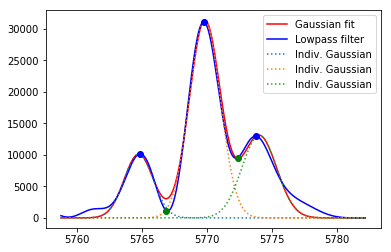

In [17]:
plt.plot(photE,GaussAdd,"r-",label='Gaussian fit')
plt.plot(photE,lowpass(lowpassdata,lpcutoff).data()[:,1],"b-", label='Lowpass filter')
for i in range(n):
    plt.plot(photE,gaussResults[i,:],":", label='Indiv. Gaussian')
for k in range(len(Maxes)):
    plt.plot(MaxIndices[k],Maxes[k],'bo')
for j in range(len(realMins)):
    plt.plot(mIndices[j],realMins[j],'go')
plt.legend()

### Running over all spectra

Plotting only spectra with significant overlap

In [18]:
tresh = 0.05

Starting spectrum 0


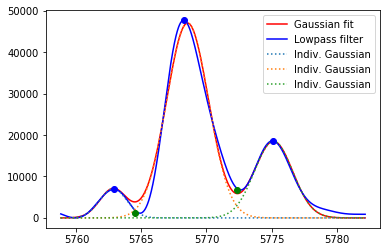

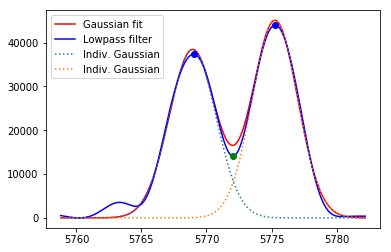

Starting spectrum 10


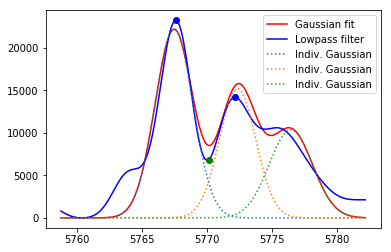

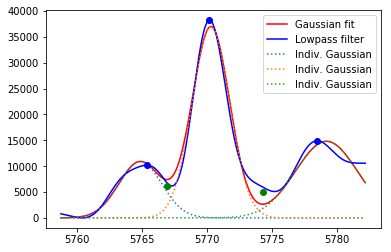

Starting spectrum 20


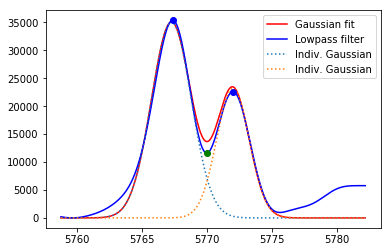

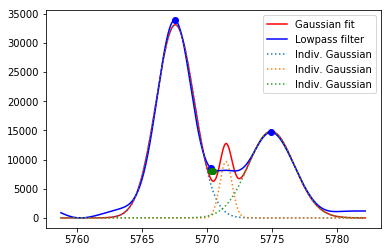

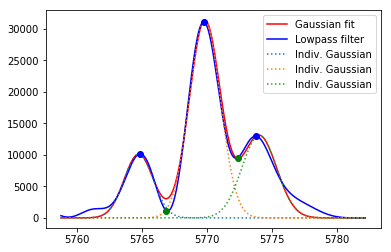

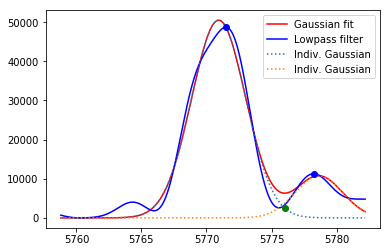

Starting spectrum 30


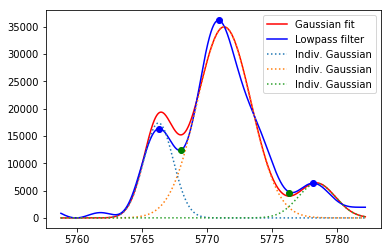

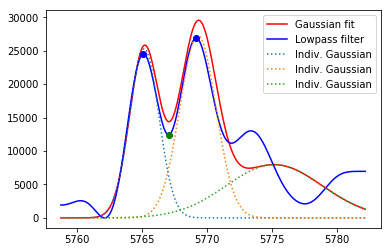

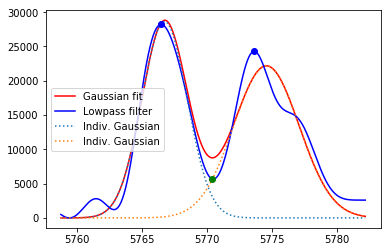

Starting spectrum 40


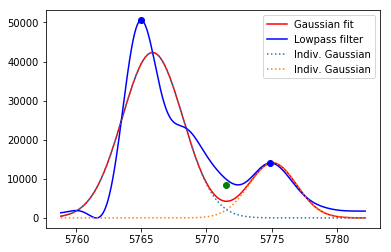

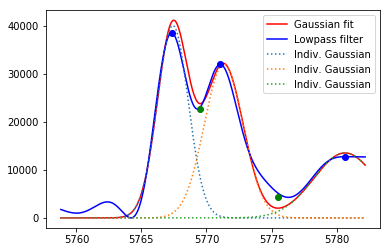

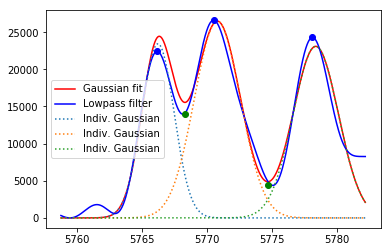

Starting spectrum 50


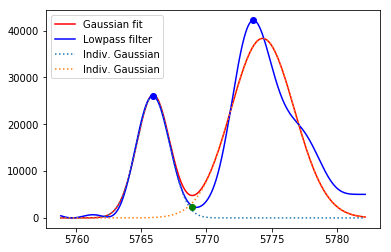

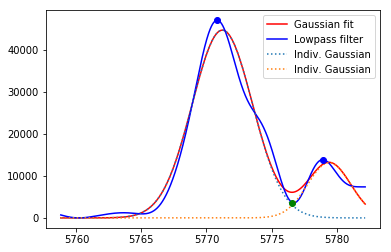

Starting spectrum 60


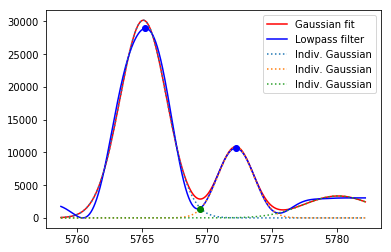

Starting spectrum 70


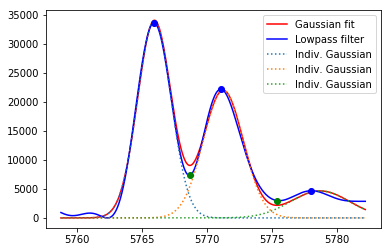

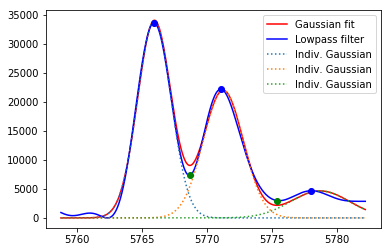

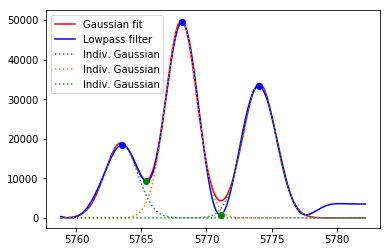

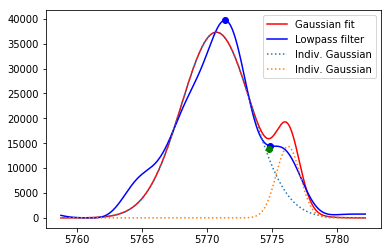

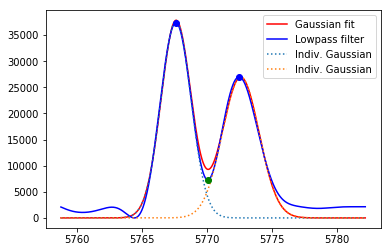

Starting spectrum 80


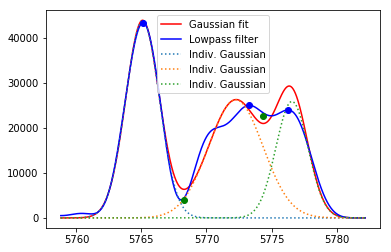

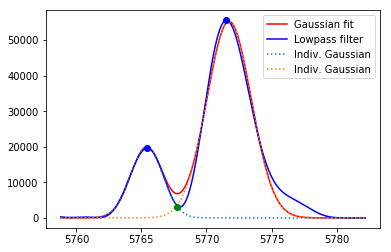

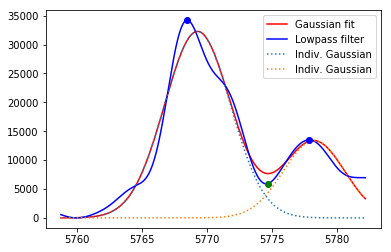

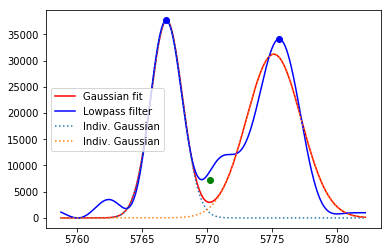

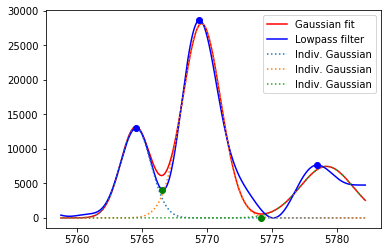

Starting spectrum 90


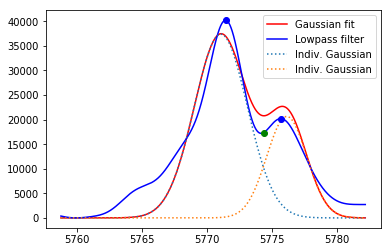

1314.457227230072


In [38]:
start = time.time()
for y in spectrum:
    if y%10 == 0:
        print("Starting spectrum", y)
    lowpassdata = intense[y,:]
    
    fn = FilterPeaks(lowpassdata,lpcutoff, dx, sidecut)
    
    # since single peak functions will not have overlaps, we filter them out already here
    if fn.n > 1:
        cond = fn.EliminatePeaks()
        n = cond.shape[1]
    
        gaussResults = Gauss(n,FindPeaks(lowpassdata,lpcutoff).pospeaks(),lowpass(lowpassdata,lpcutoff).data()).indiv()

        # Creating full Gaussian for comparison
        j = 0
        GaussAdd = []
        while j < len(gaussResults[1]):
            GaussAdd = np.append(GaussAdd, 0)
            for i in range(0,n):
                GaussAdd[j] = GaussAdd[j] + gaussResults[i,j]
            j = j+1

        func = MaxMin(GaussAdd, lowpass(lowpassdata,lpcutoff).data())

        Maxes = func.getMaxes()
        realMins = func.getrealMins()
        mIndices = func.getmIndices()
        MaxIndices = func.getMaxIndices()
        GMin = func.getGmin()
        GMax = func.getGmax()

        overlaps = []
        count = 0
        for m in range(len(realMins)):    
            mindif = abs(GMin[m]-realMins[m])
            if mindif > tresh * max(lowpass(lowpassdata,lpcutoff).data()[:,1]):
                overlaps = np.append(overlaps, i)
                if count == 0:
                    plt.plot(photE,GaussAdd,"r-",label='Gaussian fit')
                    plt.plot(photE,lowpass(lowpassdata,lpcutoff).data()[:,1],"b-", label='Lowpass filter')
                    for w in range(n):
                        plt.plot(photE,gaussResults[w,:],":", label='Indiv. Gaussian')
                    for k in range(len(Maxes)):
                        plt.plot(MaxIndices[k],Maxes[k],'bo')
                    for j in range(len(realMins)):
                        plt.plot(mIndices[j],realMins[j],'go')
                    plt.legend()
                    plt.show()
                count = count + 1
end = time.time()
print(end - start)


In [ ]:
for t in overlaps:
    spectra = intense[:,]

### CLASSES

In [2]:
class lowpass:
    # Main Butterworth lp function
    def __init__(self,lowpassdata, lpcutoff):
        self.lowpassdata = lowpassdata
        self.lpcutoff = lpcutoff
    
        b, a = signal.butter(deg, self.lpcutoff, 'low')
        self.spec = signal.filtfilt(b, a, self.lowpassdata)
    
    
    # Other useful data
    def shift(self):                                    # Min of filtered dataset defines shift
        self.shift = min(self.spec)
        return self.shift
    def MaxPeak(self):                                  # Max of filtered dataset
        MaxPeak = max(self.spec)
        return MaxPeak
    def dataRawS(self):                                 # Shifted raw data
        drs = np.array([photE,self.lowpassdata-shift()]).T
        return drs
    def Noise(self):                                    # Noise data
        noise = np.array([photE,self.lowpassdata-self.spec]).T
        return noise
    def IIData(self):                                   # Total shifted spectrum
        IIData = sum(self.spec-shift())
        return IIData
    def IINoise(self):                                  # Total of noise data
        IINoise = sum(self.lowpassdata-self.spec)
        return IINoise
    def IIDataRaw(self):                                # Total of raw spectral values
        IIDataRaw = sum(self.lowpassdata)
        return IIDataRaw
    def data(self):                                     # Full shifted dataset, including x-axis
        self.data = np.array([photE,self.spec-self.shift()]).T
        return self.data
    
    # Plot function
    def plotlowpass(self):                                                     
        plt.plot(photE, self.lowpassdata, label='Raw data')
        plt.plot(photE, self.spec, label='Filtered')
        plt.plot(photE, self.data()[:,1],label = 'Shift adjusted')
        plt.plot(photE, self.Noise()[:,1],label = 'Noise')
        plt.legend()
    

In [3]:
class FindPeaks:
    def __init__(self, rawData, cutoff):
        self.rawData = rawData
        self.cutoff = cutoff
        
        # Standard deviation is standard deviation of noise
        fn = lowpass(self.rawData, self.cutoff)
        self.SD = np.std(fn.Noise())
        
        self.Data = fn.data()
        self.h = (max(self.Data[:,1]*heightcut/100))
    
    # Finding peaks and positions
    
    def peaks(self):
        p = sp.signal.find_peaks(self.Data[:,1], height = self.h) # left out conditions as to include all in Gaussian approx
        self.peaks = np.asarray(p)
        return self.peaks
    def pospeaks(self):
        self.pospeaks = np.asarray(np.asarray(self.peaks())[0])
        return self.pospeaks
    def xpeaks(self):
        self.xpeaks = np.asarray(self.Data[self.pospeaks(),0])
        return self.xpeaks
    def ypeaks(self):
        self.ypeaks = np.asarray(self.peaks[0])
        return self.ypeaks
    
    # Peak dataset
    
    def CollectedPeaks(self):
        Peaks = np.array([self.xpeaks,self.ypeaks])
        return Peaks

In [36]:
class FilterPeaks:
    def __init__(self, rawData, cutoff, dx, sidecut):
        self.rawData = rawData
        self.cutoff = cutoff
        
        fn = FindPeaks(self.rawData, self.cutoff)
        self.xpeaks = fn.xpeaks()
        self.ypeaks = fn.ypeaks()
        self.n = len(self.xpeaks)
        self.Peaks = fn.CollectedPeaks()
        self.dx = dx
        self.sidecut = sidecut
        
    def EliminatePeaks(self):
        # close peaks elim
        dx = self.dx
        peaks = self.Peaks
        for j in range(self.n):
            if np.sort(abs(self.xpeaks-self.xpeaks[j]))[1] < dx:
                peaks = np.delete(peaks[j])
                self.pospeaks = peaks[:,0]
                self.xpeaks = fn.Data[self.pospeaks,0]
                self.ypeaks = peaks[:,1]
        self.Peaks = np.array([self.xpeaks,self.ypeaks])
        self.n = len(self.xpeaks)
        return self.Peaks 
"""      
        # edge peaks elim
        sidecut = self.sidecut
        peaks = self.Peaks
        counter = 0
        for e in range(self.n):
            #print(self.n,peaks[e].shape)
            if abs(self.xpeaks[e] - max(photE)) < ((max(photE) - min(photE))*sidecut/100) or abs(self.xpeaks[e] - min(photE)) < ((max(photE) - min(photE))*sidecut/100) and counter == 0:
                peaks = np.delete(peaks[e])
                self.pospeaks = peaks[:,0]
                self.xpeaks = fn.Data[self.pospeaks,0]
                self.ypeaks = peaks[:,1]
                counter = counter + 1
        self.Peaks = np.array([self.xpeaks,self.ypeaks])""" 
        

'      \n        # edge peaks elim\n        sidecut = self.sidecut\n        peaks = self.Peaks\n        counter = 0\n        for e in range(self.n):\n            #print(self.n,peaks[e].shape)\n            if abs(self.xpeaks[e] - max(photE)) < ((max(photE) - min(photE))*sidecut/100) or abs(self.xpeaks[e] - min(photE)) < ((max(photE) - min(photE))*sidecut/100) and counter == 0:\n                peaks = np.delete(peaks[e])\n                self.pospeaks = peaks[:,0]\n                self.xpeaks = fn.Data[self.pospeaks,0]\n                self.ypeaks = peaks[:,1]\n                counter = counter + 1\n        self.Peaks = np.array([self.xpeaks,self.ypeaks])'

In [39]:
# Approximating individual peaks (after filtering for close & edgy peaks) with Gaussians
# Here, it is made sure that any data cut out from previous filtering is then accounted for in neighbouring Gaussian
class Gauss:
    def __init__(self, n, pospeaks, data):
        self.data = data
        self.pospeaks = pospeaks
        self.n = n
        
    def indiv(self):
        n = self.n
        Data = np.asarray(self.data)
        d = Data[:,1]
        pospeaks = np.asarray(self.pospeaks)
        oldpos = 0
        fwhm = []
        sigma = []
        gaussResults = []
        
        # Slicing the dataset
        for i in range(n):
            #print(i,n,pospeaks.shape)
            if i != n-1:
                minimumy = min(d[pospeaks[i]:pospeaks[i+1]])
                position = np.asarray(np.where(d == minimumy))
            else:
                pass
            if i == 0:
                slices = np.array(d[:int(position)])
                #plt.plot(photE[:int(position)],slices, label = "orig")
            elif i != n-1:
                slices = np.array(d[oldpos:int(position)])
                #plt.plot(photE[oldpos:int(position)],slices)
            else:
                slices = np.array(d[int(position):])
                #plt.plot(photE[int(position):],slices)   

                
            # Creating dataset of individual peaks, zero value outside its own slice
            
            spfs = []
            j = 0
            while j < len(d):
                if i == n-1:
                    if j < int(position):
                        spfs = np.append(spfs,0)
                    else:
                        spfs = np.append(spfs,slices[j-oldpos])
                else:
                    if j < int(position) and j >= oldpos:
                        spfs = np.append(spfs,slices[j-oldpos])
                    else:
                        spfs = np.append(spfs,0)
                j = j + 1
            oldpos = int(position)
            
            # Approximating each peak by Gaussian
            # Plotting each Gaussian and printing FWHM and sigma
    
            mod = GaussianModel()
            pars = mod.guess(spfs, x=Data[:,0])
            out = mod.fit(spfs, pars, x=Data[:,0])
            fwhm.append(out.params['fwhm'].value)
            sigma.append(out.params['sigma'].value)
            #print("FWHM width of peak", i+1,": ",out.params['fwhm'].value)
            #print("Sigma of peak", i+1,": ",out.params['sigma'].value)
            gaussResult = out.best_fit
            if i == 0:
                gaussResults = gaussResult
            else:
                gaussResults = np.vstack((gaussResults,gaussResult))
            #plt.plot(photE,gaussResult, label = "Gaussian")
            #globals()["peakwidth%i"%i] = out.params['fwhm'].value
            #globals()["sigma%i"%i] = out.params['sigma'].value
            
        # returning individual Gaussians as single dataset
        #plt.plot(photE,lowpass(lowpassdata,lpcutoff).data()[:,1], label = "Filtered data")
       # plt.legend()
        return gaussResults

In [6]:
# This is a twin class to the previous class, which includes the plot for testing for a specific spectrum
class Gaussp:
    def __init__(self, n, pospeaks, data):
        self.data = data
        self.pospeaks = pospeaks
        self.n = n
        
    def indiv(self):
        n = self.n
        Data = np.asarray(self.data)
        d = Data[:,1]
        pospeaks = np.asarray(self.pospeaks)
        oldpos = 0
        fwhm = []
        gaussResults = []
        
        # Slicing the dataset, plotting each slice
        for i in range(n):
            print(i,n)
            if i != n-1:
                minimumy = min(d[pospeaks[i]:pospeaks[i+1]])
                position = np.asarray(np.where(d == minimumy))
            else:
                pass
            if i == 0:
                slices = np.array(d[:int(position)])
                #plt.plot(photE[:int(position)],slices, label = "orig")
            elif i != n-1:
                slices = np.array(d[oldpos:int(position)])
                #plt.plot(photE[oldpos:int(position)],slices)
            else:
                slices = np.array(d[int(position):])
                #plt.plot(photE[int(position):],slices)   

                
            # Creating dataset of individual peaks, zero value outside its own slice
            
            spfs = []
            j = 0
            while j < len(d):
                if i == n-1:
                    if j < int(position):
                        spfs = np.append(spfs,0)
                    else:
                        spfs = np.append(spfs,slices[j-oldpos])
                else:
                    if j < int(position) and j >= oldpos:
                        spfs = np.append(spfs,slices[j-oldpos])
                    else:
                        spfs = np.append(spfs,0)
                j = j + 1
            oldpos = int(position)
            
            # Approximating each peak by Gaussian
            # Plotting each Gaussian and printing FWHM and sigma
    
            mod = GaussianModel()
            pars = mod.guess(spfs, x=Data[:,0])
            out = mod.fit(spfs, pars, x=Data[:,0])
            fwhm.append(out.params['fwhm'].value)
            
            print("FWHM width of peak", i+1,": ",out.params['fwhm'].value)
            print("Sigma of peak", i+1,": ",out.params['sigma'].value)
            gaussResult = out.best_fit
            if i == 0:
                gaussResults = gaussResult
            else:
                gaussResults = np.vstack((gaussResults,gaussResult))
            plt.plot(photE,gaussResult, label = "Gaussian")
            globals()["peakwidth%i"%i] = out.params['fwhm'].value
            globals()["sigma%i"%i] = out.params['sigma'].value
            
        # returning individual Gaussians as single dataset
        plt.plot(photE,lowpass(lowpassdata,lpcutoff).data()[:,1], label = "Filtered data")
        plt.legend()
        return gaussResults

In [7]:
# Class to find the minima and maxima of smoothened raw data, based on min/max of Gaussian
class MaxMin:
    def __init__(self, GaussAdd, data):
        self.GaussAdd = GaussAdd
        self.data = data
        
        
        # Finding peaks of added Gaussians
        GPeaks = sp.signal.find_peaks(self.GaussAdd,
                             height=1000,
                             prominence = max(self.GaussAdd)/20)
        # height of peaks
        GPeaksh = (GPeaks[1])["peak_heights"]
        # position of peaks
        GPeaks = np.asarray(np.asarray(GPeaks)[0])
        
        # Finding corresponding real maxes within given range (1 20th of spectrum) of Gaussian max
        Maxes = []
        MaxIndices = []
        for i in GPeaks:
            Range = int(len(self.GaussAdd)/20)
            realMax = max((self.data[:,1])[i-Range:i+Range])
            Maxes = np.append(Maxes,realMax)
            maxIndex = np.where(self.data[:,1] == realMax)
            maxIndex = photE[int(np.asarray(maxIndex))]
            MaxIndices = np.append(MaxIndices,maxIndex)
            
        # Similarly for mins, taking only minima between maxima, i.e. where there is significant overlap
        realMins = []
        mIndices = []
        Range = int(len(self.GaussAdd)/20)
        gaussMins = []
        if len(Maxes) > 1:
            # Finding overlapping points
            for i in range(len(Maxes)-1):
                index1 = int(np.asarray(np.where((self.data[:,1]) == Maxes[i])))
                index2 = int(np.asarray(np.where((self.data[:,1]) == Maxes[i+1])))
                gaussMin = min(self.GaussAdd[index1:index2])
                gaussMins = np.append(gaussMins,gaussMin)
                mIndex = int(np.asarray(np.where(self.GaussAdd == gaussMin)))
                realMin = min((self.data[:,1])[int(mIndex-Range):int(mIndex+Range)])
                realMins = np.append(realMins,realMin)
                mIndex = photE[int(np.asarray(mIndex))]
                mIndices = np.append(mIndices,mIndex)
                
        self.Maxes = np.asarray(Maxes)       
        self.realMins = np.asarray(realMins)
        self.mIndices = np.asarray(mIndices)
        self.MaxIndices = np.asarray(MaxIndices)
        self.GMax = GPeaksh
        self.GMin = gaussMins
        
    def getMaxes(self):
        return self.Maxes
    def getrealMins(self):
        return self.realMins
    def getmIndices(self):
        return self.mIndices
    def getMaxIndices(self):
        return self.MaxIndices
    def getGmin(self):
        return self.GMin
    def getGmax(self):
        return self.GMax
        